# Chaines de Markov et épidémiologie : propagation d’une épidémie dans une population


L’objectif de ce projet est de manipuler des chaînes de Markov pour étudier la propagation d’une épidémie dans une population.

## Partie 1 : Apprentissage des paramètres d’un modèle à partir de données

Dans notre modèle, nous allons considérer qu’à chaque temps :
- chaque individu sain peut rester sain ou devenir infecté
- chaque individu infecté peut rester infecté ou devenir guéri
- chaque individu guéri reste guéri

et que la probabilité de passer d’un état à l’autre **ne dépend que de l’état précédent**.

Nous disposons d’une séquence d’observations et nous souhaitons apprendre les paramètres de la chaîne de Markov permettant de modéliser le processus sous-jacent qui a généré la séquence.

En suivant un individu pendant 10 jours on obtient donc la séquence d'observation suivante : $S, S, S, I, I ,I ,I , I, I, R$

On peut donc en déduire la matrice de probabilité de transition suivante :

|  |S | I | R |
| :--|:--:| :--:|--:|
|S   | 2/3 |1/3  |0|
|I   | 0 | 5/6 |1/6|
|R   |0    |  0  |1|


In [91]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Quelques fonctions utiles que nous utiliserons par la suite

#Trace un graphique
def graph(x, y ,titre,xlabel,ylabel):
    plt.figure(figsize=(5, 3))
    plt.title(titre)
    plt.plot(x, y[:,0], label='Sain (S)')
    plt.plot(x, y[:,1], label="Infecté (I)")
    plt.plot(x, y[:,2], label="Guéri (R)")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

#Trace un histogramme
def histogramme(x,y,titre, barlabel, xlabel, ylabel):
    fig = plt.figure(figsize=(7, 5))
    plt.title(titre)
    plt.bar(x,y, label = barlabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

#Trace un histogramme avec 2 bar
def histogramme2(x1,y1, titre, barlabel1, x2,y2, barlabel2, xlabel, ylabel):
    fig = plt.figure(figsize=(7, 5))
    plt.title(titre)
    plt.bar(x1-0.3,y1,0.6, label = barlabel1)
    plt.bar(x2+0.3,y2,0.6, label = barlabel2)
    plt.xlabel(xlabel)
    plt.ylabel("Nombre d'individus")
    plt.legend()
    plt.show()


Nous avons ensuite suivi une population de 5000 individus, pendant 200 jours, et obtenons donc la matrice de probabilité de transition suivante :

In [92]:
data = np.loadtxt("data_ex1.txt", dtype =int) # Lecture des données

# 0 --> Sain (S)
# 1 --> Infecté (I)
# 2 --> Guéri (R)

def probas(data):
    m = np.zeros((3,3), dtype= float) #Création d'une matrice initialisée à 0
    prec = 9 #Declaration d'une variable précédent


    for individu in data : 
        for state in individu :
            if prec == 9 : #Si c'est la premiere valeur pour un individu on passe au suivant et on le met dans le precedent
                prec = state
                continue
            else : # Sinon on compte la transition dans la matrice m (precedent -> state)
                m[prec][state]+=1
            prec = state
        prec = 9 #A la fin de chaque individu il n'y a plus de precedent

    sum = np.sum(m,axis=1) #On somme toute les lignes
    
    for i in range(3) :
        for j in range(3) :
            m[i][j] = m[i][j]/sum[i] #On chaque case par le nombre total de transition dans une ligne
    
    return m
            


matrice = probas(data)
print(matrice)

[[0.93082918 0.06917082 0.        ]
 [0.         0.93518148 0.06481852]
 [0.04065945 0.         0.95934055]]


## Partie 2 : Description du premier modèle


Grâce au graphe de transition du document 1 on obtient la matrice de transition A suivante :

|  |S | I | R |
| :--|:--:| :--:|--:|
|S   |0.92 | 0.08 |  0 |
|I   | 0   | 0.93 |0.07|
|R   |  0  |  0   |  1 |

In [93]:
A = np.array([[.92, .08, .0], [.0, .93, .07], [.0, .0, 1.]])
print(A)

[[0.92 0.08 0.  ]
 [0.   0.93 0.07]
 [0.   0.   1.  ]]


Vérifions si elle est stochastique

In [94]:
def stochastique(matrice) :
    # Verifie si toute les valeurs sont >= 0 et que la sommme de chaque ligne est égale à 1
    return np.all(matrice >= 0 ) and np.all(np.sum(matrice, axis=1)) == 1

print(stochastique(matrice))

True


La matrice est donc stochatstique.

Au temps $t = 0$, un individu a une probabilité de 0.9 d’être sain et 0.1 d’être infecté.
Soit $\pi_0$ la distribution de la probabilité initiale.

On a donc $\pi_0 = [0.9;0.1;0]$

In [95]:
pi0 = np.array([0.9,0.1,0])
print("pi0 = ",pi0)

pi0 =  [0.9 0.1 0. ]


### Distribution :

Au temps $t = 1$ on a donc $\pi_0 \times A$ donc $\pi_1 = [0.828;0.165;0.007]$

In [96]:
pi1 = np.dot(pi0,A)
print("pi1 =",pi1)

pi1 = [0.828 0.165 0.007]


Au temps $t = 2$ on a donc $\pi_1 \times A$ donc $\pi_2 = [0,76176;0,21969;0,01855]$

In [97]:
pi2 = np.dot(pi1,A)
print("pi2 = ",pi2)

pi2 =  [0.76176 0.21969 0.01855]


Afin de calculer la distribution théorique des effectifs dans chaque état on doit donc calculer $\pi_t$ à chaque temps $t$

On a donc
$$ \pi_{t+1}=\pi_{t}\times A = (\pi_{t-1}\times A)\times A = \pi_0 \times A^t $$

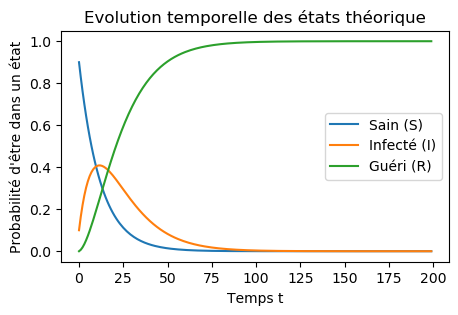

In [98]:
def distribution(pi0,a,t):
    # Calcule la distribution théorique suivant un temps t
    return np.matmul(pi0,np.linalg.matrix_power(a,t))


T = np.arange(200) #temps (axe des abscisses)

pi_t = np.zeros((200, 3)) #Tableau qui contiendra les probabilités des états pour chaque temps

#A chaque temps t on calcule la distribution théorique
for i in range(0, 200):
    pi_t[i] = distribution(pi0,A,i)

graph(T, pi_t,"Evolution temporelle des états théorique","Temps t", "Probabilité d'être dans un état")


On observe donc que le taux de personne saines décroît très rapidement suivant le temps, tandis que le taux de de personne guéries croit. Le taux de personnes infectées connaît un pic et décroît rapidement.

### Tirage aléatoire des états

Nous allons maintenant générer une séquence de taille T en utilisant cette chaine de Markov. Pour générer cette séquence aléatoire, nous allons choisir un état initial au hasard; puis choisir les états suivants en suivant les probabilités de transition.

In [99]:
def gen_sequences(A,pi0, t):
    #Genere une sequence aléatoire pour un individu sur un temps t
    seq = np.zeros(t)
    #choisis parmis 0.,1.,2. avec les probabilités de pi0
    seq[0] = np.random.choice([0.,1.,2.],1, p = pi0) 
    
    for i in range(1,t):
        #Genere une nouvelle valeur en fonction de la valeur précédente
        seq[i] = np.random.choice([0.,1.,2.],1, p=A[int(seq[i-1])])
    return seq

print(gen_sequences(A,pi0,150))



[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.]


### Modélisation d'une population

Modélisons maintenant une séquence d'état pour une population de 200 individus.

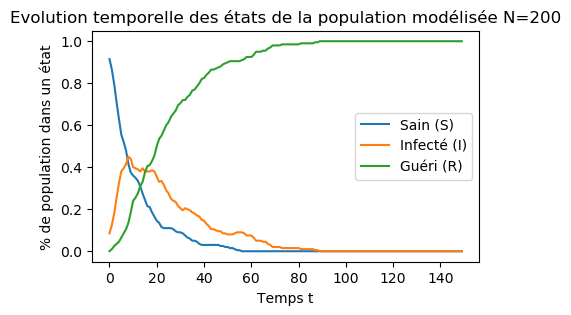

In [100]:
def gen_sequences_population(A,pi0,n, t):
    #Genere des sequences aléatoires pour une population de taille n sur un temps t
    seq = np.zeros((n,t))
    for i in range(n):
        seq[i] = gen_sequences(A, pi0, t)
    return seq

p=gen_sequences_population(A,pi0,200,150)


def compteur(sequence,t,taille):
    #Compte le nombre de personnes dans chaque état à un temps t
    res = np.zeros((t,3))
    for i in range (len(sequence)):
        for j in range (len(sequence[0])):
            if sequence[i][j] == 0:
                res[j][0]+=1
            if sequence[i][j] == 1:
                res[j][1]+=1
            if sequence[i][j] == 2:
                res[j][2]+=1
    res/=taille
    return res

repartition = compteur(p,150,200)
T = np.arange(150)
graph(T,repartition,"Evolution temporelle des états de la population modélisée N=200","Temps t","% de population dans un état")

On remarque donc que quand t est grand le taux de personnes saines et infectées sont nulles tandis que le taux de personnes infectées est au maximum. De même ce graphe ressemble à celui théorique ce qui est normal. Cependant il n'est pas "parfait" car il n'y a pas assez de valeurs

Avec une population de taille 5 nous retrouvons le graphe suivant :

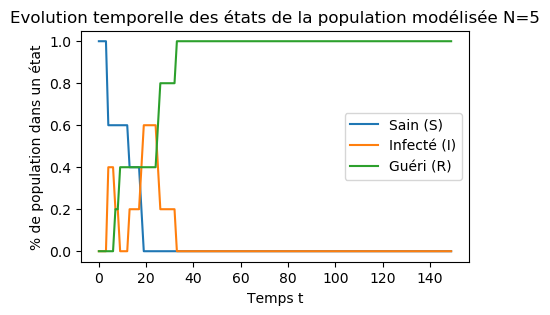

In [101]:
seq5 = gen_sequences_population(A,pi0,5,150)
prop5 = compteur(seq5,150,5)
graph(T, prop5, "Evolution temporelle des états de la population modélisée N=5","Temps t","% de population dans un état")

Etant donné que ce graphe n'a encore moins de valeurs que le précédent, il ne ressemble encore moins à celui théorique.

Avec une population de taille 5000 nous retrouvons le graphe suivant :

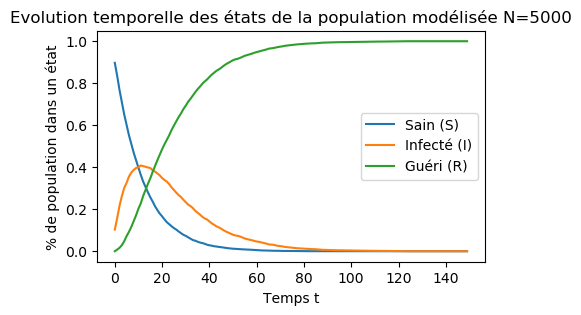

In [102]:
seq5000 = gen_sequences_population(A,pi0,5000,150)
prop5000 = compteur(seq5000,150,5000)

graph(T, prop5000, "Evolution temporelle des états de la population modélisée N=5000","Temps t","% de population dans un état")

On remarque que les résultats retrouvés avec une population de taille 5, de taille 200 et de taille 5000 se ressemblent quand t est grand, et que plus la population est grande plus le graphe va ressembler à celui théorique.

### Longueur de l'infection

Estimons maintenant la longueur moyenne d'une infection :

In [103]:
def moyenneI(sequences,t,n):
    #Calcule la longueur moyenne d'une infection
    
     #Compte pour chaque individus la longueur de sa séquence de I
    r = np.count_nonzero(sequences == 1. , axis=1)
    res = np.sum(r)/n
    return res

moy = moyenneI(seq5000, 150, 5000)
print("Le temps d'infection moyen sur une population de 5000 individus est donc de :", moy)

Le temps d'infection moyen sur une population de 5000 individus est donc de : 14.129


[ 4 32 28  6  2  5 14  6  3 71  1 10 14  2  2 38  6  7 15 23 10 61 11 34
  7 72  7  4 46 16  6 14  4  7  7 54 35  3  2  8  3  7  7  9 15 24  8  6
  4  5 13 14  7 14  4 46  8  1  3  1  7  6 37  4 22  1  2 11 16  3  2  1
 46  4  9 11 13  5 14  4  8 11 30  6 45  2 22 15 67 57  4 11 13  5  2  6
 27 19  4 25 17  8 16  2 15 22  2  4  3 10 11 23 28  5  2 17 29 14  5 15
  9 21  9  3 10 13 46 13 27 11 17  6 18 33 10  1  1  4  6  9 31  5 20  1
 14 30 34 25 16  1  4 15  9 12  1  2 24 11 28 13  3 30 33  5 37  1  6  4
  3  1 14  9 42 16  2 11 16 13  1  6  2 28 28  7 11  8  5  2  4 54  6 11
 45  4  9  9 18  4  1 30]


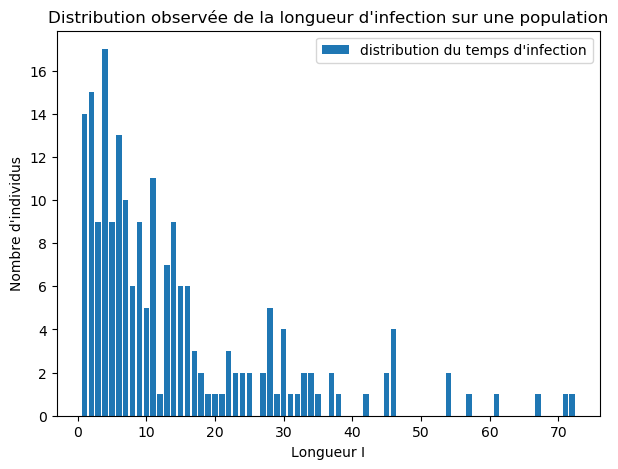

In [104]:
a = np.count_nonzero(p == 1. , axis=1)
print(a)
val , indices = np.unique(a, return_counts=True)

histogramme(val, indices, "Distribution observée de la longueur d'infection sur une population",
            "distribution du temps d'infection","Longueur I", "Nombre d'individus")

Calculons maintenant la longueur théorique d'une séquence de I.

La probabilité que le temps d'infection soit égal à 1 est de $P(L == 1) = P(IR)$

La probabilité que le temps d'infection soit égal à 2 est de $P(L == 2) = P(IIR) = P(II)\times P(IR)$

Notons alors $P(IR) = p$

Donc on a pour un temps t, le temps d'infection est égal à $P(L == t) = P(II)^{t-1} \times p$

Cela correspond donc a une loi géometrique de probabilité p = 0.07

La longueur théorique d'une séquence de I pour t = 0 est donc de : 14.285714285714285


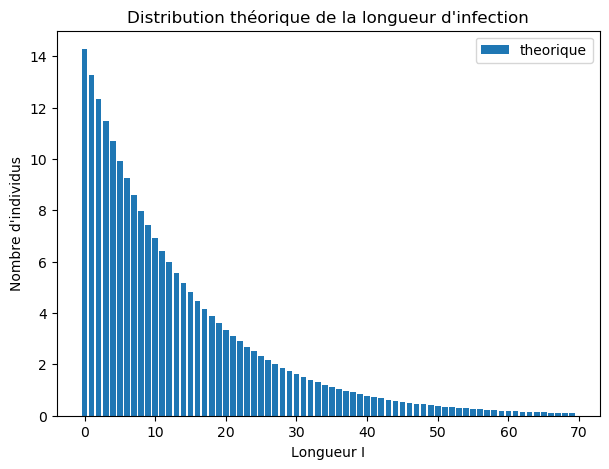

In [105]:
#Probabilité d'être dans l'état I et de passer à l'état R
p = A[1][2]

print("La longueur théorique d'une séquence de I pour t = 0 est donc de :",1/p)

longueur_i = np.zeros_like(a, dtype= float)
for i in range (0,len(a)):
    longueur_i[i] = (1-p)**i*(1/p)

L = np.arange(70)
histogramme(L, longueur_i[:70],"Distribution théorique de la longueur d'infection","theorique",
            "Longueur I", "Nombre d'individus")

Comparons alors ces deux distributions.

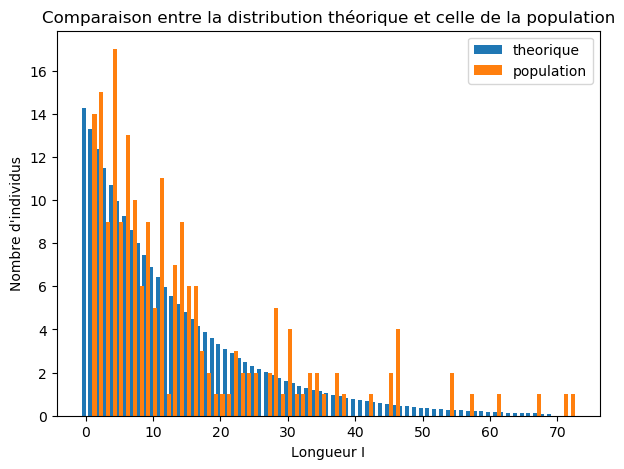

In [106]:
histogramme2(L, longueur_i[:70],"Comparaison entre la distribution théorique et celle de la population",
             "theorique",val,indices,"population","Longueur I", "Nombre d'individus")

On remarque donc que les deux distributions se ressemblent, plus la longueur de I est grande moins il y a d'individus dans ces cas.

# Modification autour de ce premier modèle
Modifions alors la taille de la population et observons 

Le temps d'infection moyen sur une population de 5 individus est donc de : 8.4
Le temps d'infection moyen sur une population de 50 individus est donc de : 16.92
Le temps d'infection moyen sur une population de 100 individus est donc de : 11.44
Le temps d'infection moyen sur une population de 500 individus est donc de : 14.094
Le temps d'infection moyen sur une population de 1000 individus est donc de : 15.165
Le temps d'infection moyen sur une population de 5000 individus est donc de : 14.1716


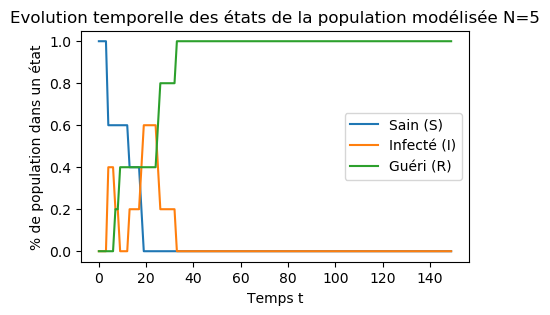

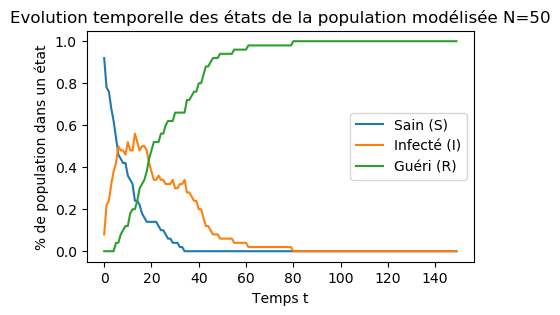

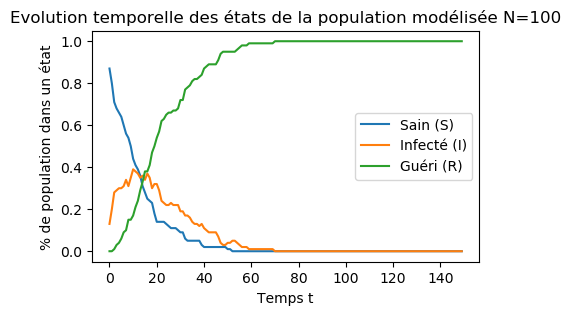

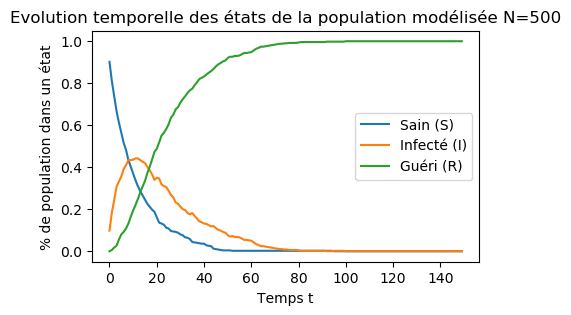

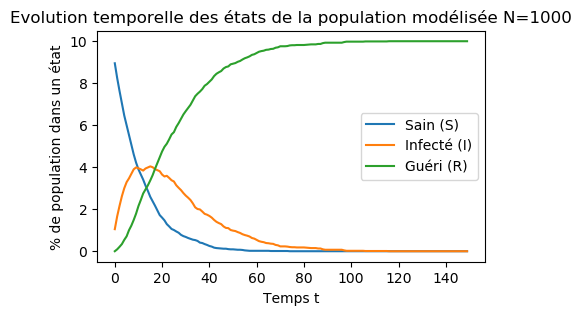

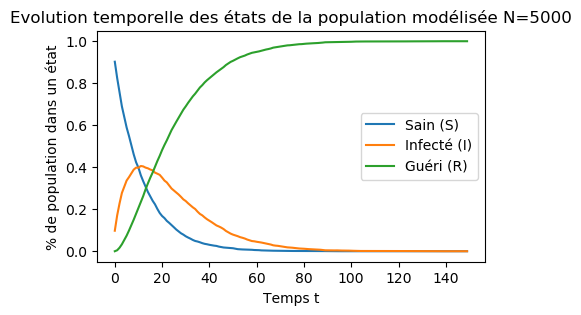

In [107]:
# Pour chaque population on génère une s"quence pour chaque individu
# Ensuite on compte le nombre de personnes dans chaque état à un temps t
# Et on affiche le temps d'infection moyen

moy5 = moyenneI(seq5, 150, 5)
print("Le temps d'infection moyen sur une population de 5 individus est donc de :", moy5)

seq50 = gen_sequences_population(A,pi0,50,150)
prop50 = compteur(seq50,150,50)
moy50 = moyenneI(seq50, 150, 50)
print("Le temps d'infection moyen sur une population de 50 individus est donc de :", moy50)

seq100 = gen_sequences_population(A,pi0,100,150)
prop100 = compteur(seq100,150,100)
moy100 = moyenneI(seq100, 150, 100)
print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100)

seq500 = gen_sequences_population(A,pi0,500,150)
prop500 = compteur(seq500,150,500)
moy500 = moyenneI(seq500, 150, 500)
print("Le temps d'infection moyen sur une population de 500 individus est donc de :", moy500)

seq1000 = gen_sequences_population(A,pi0,1000,150)
prop1000 = compteur(seq1000,150,100)
moy1000 = moyenneI(seq1000, 150, 1000)
print("Le temps d'infection moyen sur une population de 1000 individus est donc de :", moy1000)

seq5000 = gen_sequences_population(A,pi0,5000,150)
prop5000 = compteur(seq5000,150,5000)
moy5000 = moyenneI(seq5000, 150, 5000)
print("Le temps d'infection moyen sur une population de 5000 individus est donc de :", moy5000)


graph(T, prop5,"Evolution temporelle des états de la population modélisée N=5", "Temps t", "% de population dans un état" )
graph(T, prop50,"Evolution temporelle des états de la population modélisée N=50" , "Temps t", "% de population dans un état" )
graph(T, prop100,"Evolution temporelle des états de la population modélisée N=100" , "Temps t", "% de population dans un état" )
graph(T, prop500,"Evolution temporelle des états de la population modélisée N=500" , "Temps t", "% de population dans un état" )
graph(T, prop1000,"Evolution temporelle des états de la population modélisée N=1000" , "Temps t", "% de population dans un état" )
graph(T, prop5000,"Evolution temporelle des états de la population modélisée N=5000" , "Temps t", "% de population dans un état" )

Toutes les courbes se ressemblent et on remarque donc que plus la population est grande plus la courbe devient "lisse" et va donc se rapprocher de celle theorique.


Modifions maintenant la probabilité initiale $\pi_0$

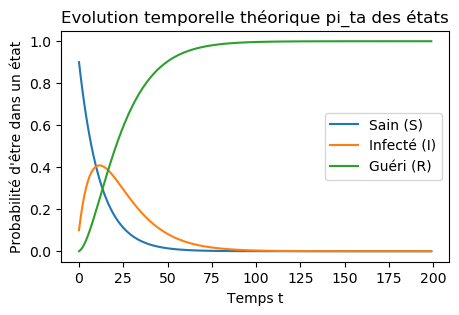

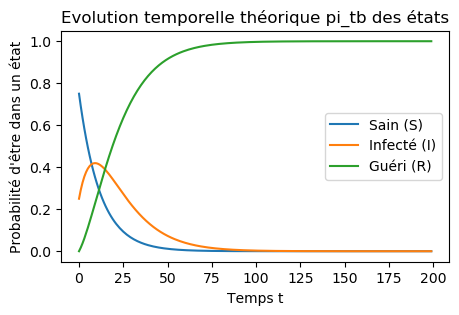

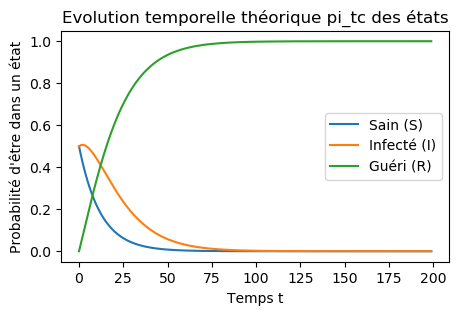

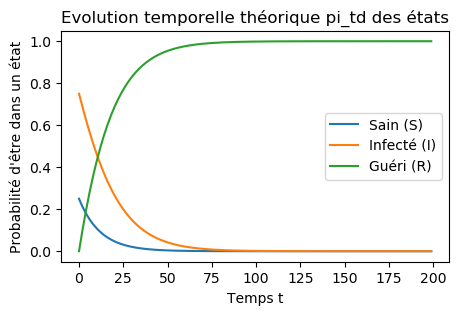

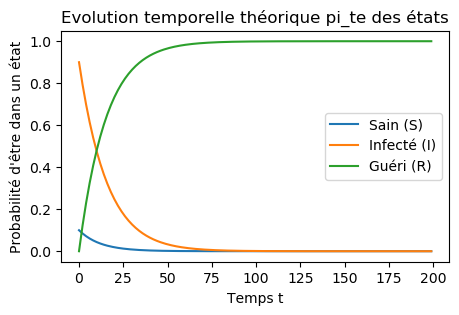

In [108]:
pi0a = np.array([0.9,0.1,0])
pi0b = np.array([0.75,0.25,0])
pi0c = np.array([0.5,0.5,0])
pi0d = np.array([0.25,0.75,0])
pi0e = np.array([0.1,0.9,0])

#On génère une séquence théorique pour chaque probabilité initiale et on l'affiche
T = np.arange(200)

pi_ta = np.zeros((200, 3))
for i in range(0, 200):
    pi_ta[i] = distribution(pi0a,A,i)
graph(T, pi_ta,"Evolution temporelle théorique pi_ta des états","Temps t","Probabilité d'être dans un état")

pi_tb = np.zeros((200, 3))
for i in range(0, 200):
    pi_tb[i] = distribution(pi0b,A,i)
graph(T, pi_tb,"Evolution temporelle théorique pi_tb des états","Temps t","Probabilité d'être dans un état")

pi_tc = np.zeros((200, 3))
for i in range(0, 200):
    pi_tc[i] = distribution(pi0c,A,i)
graph(T, pi_tc,"Evolution temporelle théorique pi_tc des états","Temps t","Probabilité d'être dans un état")

pi_td = np.zeros((200, 3))
for i in range(0, 200):
    pi_td[i] = distribution(pi0d,A,i)
graph(T, pi_td,"Evolution temporelle théorique pi_td des états","Temps t","Probabilité d'être dans un état")

pi_te = np.zeros((200, 3))
for i in range(0, 200):
    pi_te[i] = distribution(pi0e,A,i)
graph(T, pi_te,"Evolution temporelle théorique pi_te des états","Temps t","Probabilité d'être dans un état")




On remarque que toutes les courbes se ressemblent quand t est grand, et pour t petit, la probabilité d'être dans chaque état suit la probabilité initiale.

Le temps d'infection moyen sur une population de 100 individus est donc de : 14.32
Le temps d'infection moyen sur une population de 100 individus est donc de : 13.39
Le temps d'infection moyen sur une population de 100 individus est donc de : 13.43
Le temps d'infection moyen sur une population de 100 individus est donc de : 14.03
Le temps d'infection moyen sur une population de 100 individus est donc de : 13.86


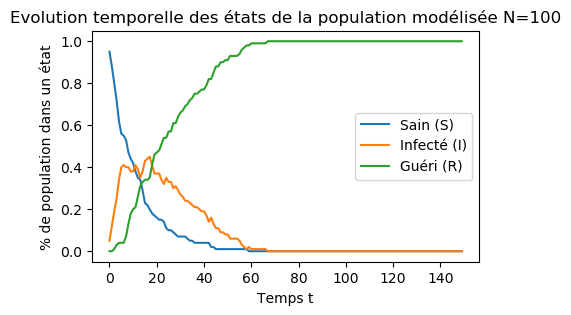

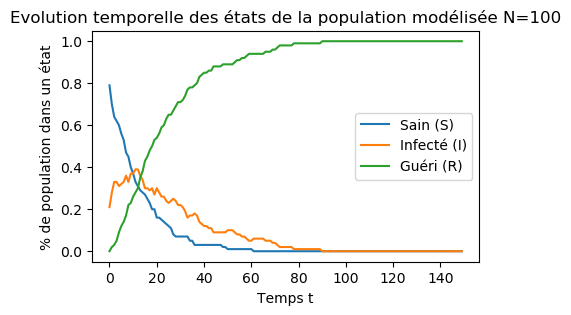

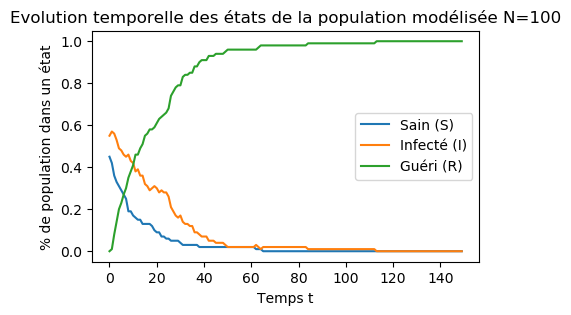

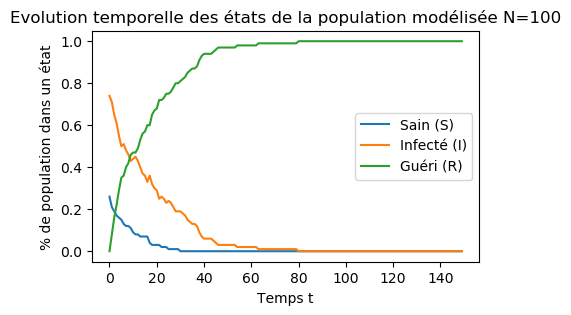

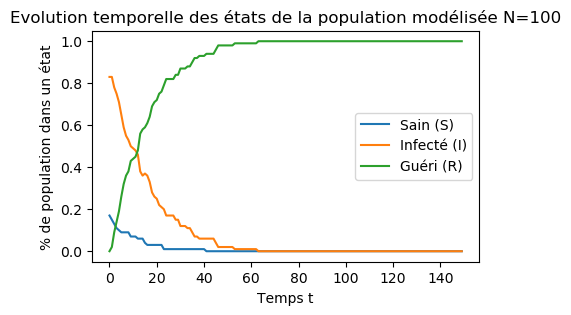

In [109]:
T = np.arange(150)

#On gérère une séquence pour chaque probabilité initiale avec une population de taille 100 et on l'affiche

seq100a = gen_sequences_population(A,pi0a,100,150)
prop100a = compteur(seq100a,150,100)
moy100a = moyenneI(seq100a, 150, 100)
print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100a)

seq100b = gen_sequences_population(A,pi0b,100,150)
prop100b = compteur(seq100b,150,100)
moy100b = moyenneI(seq100b, 150, 100)
print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100b)

seq100c = gen_sequences_population(A,pi0c,100,150)
prop100c = compteur(seq100c,150,100)
moy100c = moyenneI(seq100c, 150, 100)

print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100c)
seq100d = gen_sequences_population(A,pi0d,100,150)
prop100d = compteur(seq100d,150,100)
moy100d = moyenneI(seq100d, 150, 100)
print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100d)

seq100e = gen_sequences_population(A,pi0e,100,150)
prop100e = compteur(seq100e,150,100)
moy100e = moyenneI(seq100e, 150, 100)
print("Le temps d'infection moyen sur une population de 100 individus est donc de :", moy100e)



graph(T, prop100a,"Evolution temporelle des états de la population modélisée N=100" , "Temps t", "% de population dans un état")
graph(T, prop100b,"Evolution temporelle des états de la population modélisée N=100" , "Temps t", "% de population dans un état")
graph(T, prop100c,"Evolution temporelle des états de la population modélisée N=100" , "Temps t", "% de population dans un état")
graph(T, prop100d,"Evolution temporelle des états de la population modélisée N=100" , "Temps t", "% de population dans un état")
graph(T, prop100e,"Evolution temporelle des états de la population modélisée N=100" , "Temps t", "% de population dans un état")

De même pour ces graphes, ils ressemblent à celui théorique suivant chaque probabilité initiale.


Modifions maintenant les probabilités de transitions :

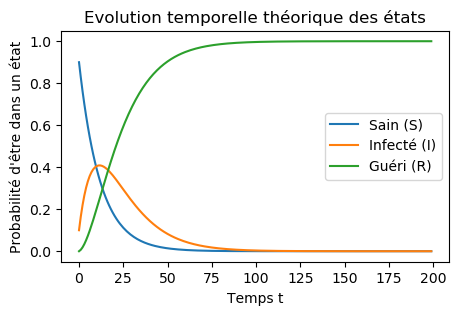

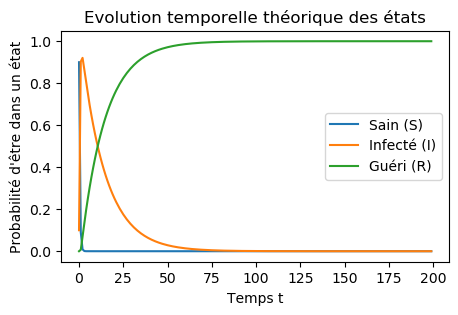

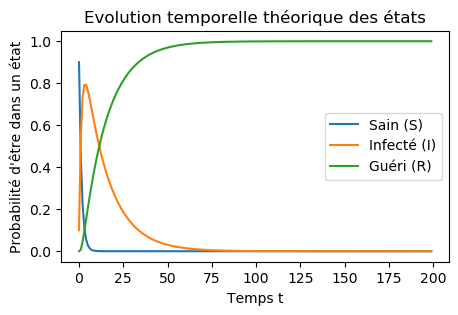

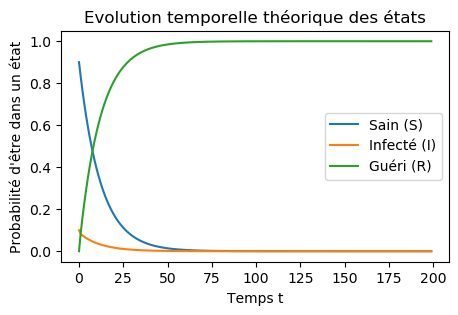

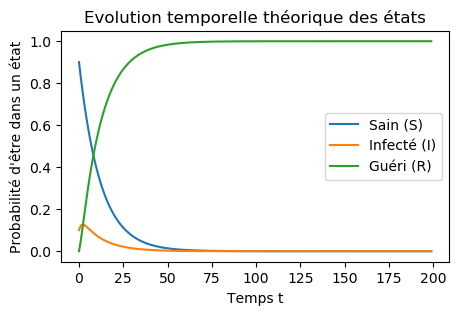

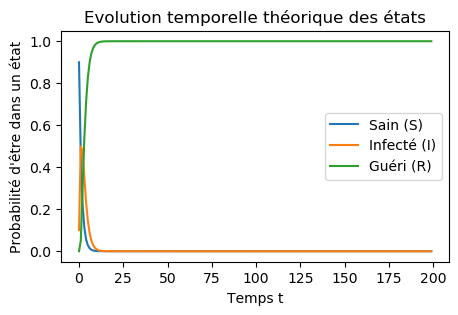

In [110]:
A = np.array([[0.92,0.08,0],[0,0.93,0.07],[0,0,1]])
B = np.array([[0.1,0.9,0],[0,0.93,0.07],[0,0,1]])
C = np.array([[0.5,0.5,0],[0,0.93,0.07],[0,0,1]])
D = np.array([[0.92,0.08,0],[0,0.1,0.9],[0,0,1]])
E = np.array([[0.92,0.08,0],[0,0.5,0.5],[0,0,1]])
F = np.array([[0.5,0.5,0],[0,0.5,0.5],[0,0,1]])

#On génère une séquence théorique pour chaque matrice de transition

T = np.arange(200)

pi_t = np.zeros((200, 3))
for i in range(0, 200):
    pi_t[i] = distribution(pi0,A,i)
graph(T, pi_t,"Evolution temporelle théorique des états","Temps t","Probabilité d'être dans un état")

pi_t = np.zeros((200, 3))
for i in range(0, 200):
    pi_t[i] = distribution(pi0,B,i)
graph(T, pi_t,"Evolution temporelle théorique des états","Temps t","Probabilité d'être dans un état")

pi_t = np.zeros((200, 3))
for i in range(0, 200):
    pi_t[i] = distribution(pi0,C,i)
graph(T, pi_t,"Evolution temporelle théorique des états","Temps t","Probabilité d'être dans un état")

pi_t = np.zeros((200, 3))
for i in range(0, 200):
    pi_t[i] = distribution(pi0,D,i)
graph(T, pi_t,"Evolution temporelle théorique des états","Temps t","Probabilité d'être dans un état")

pi_t = np.zeros((200, 3))
for i in range(0, 200):
    pi_t[i] = distribution(pi0,E,i)
graph(T, pi_t,"Evolution temporelle théorique des états","Temps t","Probabilité d'être dans un état")

pi_t = np.zeros((200, 3))
for i in range(0, 200):
    pi_t[i] = distribution(pi0,F,i)
graph(T, pi_t,"Evolution temporelle théorique des états","Temps t","Probabilité d'être dans un état")



On remarque que les courbes se ressemblent quand t est grand la probabilité d'être guéri est à 1 tandis que la probabilité d'être saint et infecté est de 0. Seulement quand t est petit il existe des variations.


## Partie 3 : Description du second modèle

### Analyse du modèle
Etudions maintenant un second modèle

Ce modèle peut être modélisé par une chaine de Markov en effet, chaque état dépend de l'état du précédent.

Grace au diagramme de transition on obtient donc la matrice de transition suivante :

|  |S | I | R |
| :--|:--:| :--:|--:|
|S   | 0.92 | 0.08 |0|
|I   | 0 | 0.93 |0.07|
|R   |  0.02 |  0  |0.98|


Les états sont tous communiquant entre eux. Cette chaine est aperiodique car il existe une boucle sur elle même à chaque état, et est irreductible

Calculons $A²$, $A³$,$A⁴$ et regardons si ces matrices sont stochastiques

In [111]:
A = np.array([[.92, .08, .0], [.0, .93, .07], [.02, .0, .98]])
print("A : ",A)
A2 = np.matmul(A,A)
print("A2 : ",A2)
print(stochastique(A2))
A3 = np.matmul(A2,A)
print("A3 : ",A3)
print(stochastique(A3))
A4 = np.matmul(A3,A)
print("A4 : ",A4)
print(stochastique(A4))

A :  [[0.92 0.08 0.  ]
 [0.   0.93 0.07]
 [0.02 0.   0.98]]
A2 :  [[0.8464 0.148  0.0056]
 [0.0014 0.8649 0.1337]
 [0.038  0.0016 0.9604]]
True
A3 :  [[0.7788   0.205352 0.015848]
 [0.003962 0.804469 0.191569]
 [0.054168 0.004528 0.941304]]
True
A4 :  [[0.71681296 0.25328136 0.02990568]
 [0.00747642 0.74847313 0.24405045]
 [0.06866064 0.00854448 0.92279488]]
True


Tous les états sont récurents et toutes les matrices sont stochastiques


Affichons la distribution theorique avec cette nouvelle matrice :

Prenons au temps t = 0 une population où tous les individus sont sains, on a alors $\pi_0 = [1,0,0]$

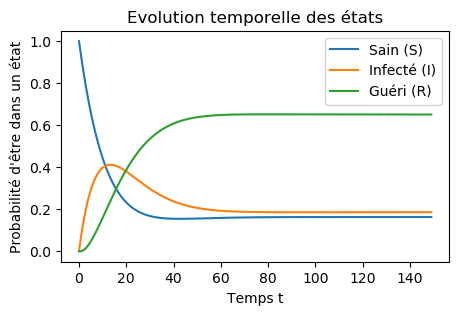

In [112]:
A = np.array([[.92, .08, .0], [.0, .93, .07], [.02, .0, .98]])
pi0 = np.array([1,0,0])

T = np.arange(150)
pi_t = np.zeros((150, 3))
for i in range(0, 150):
    pi_t[i] = distribution(pi0,A,i)
graph(T, pi_t,"Evolution temporelle des états","Temps t","Probabilité d'être dans un état")

On remarque donc qu'au bout d'un moment le taux d'individus dans chaque état stagne, le taux d'individus guéris à 0.6, et le taux d'individus infectés et sains vers 0.2

Effectuons cette experience sur une population de taille 5, 50, 100, 500, 1000, 5000

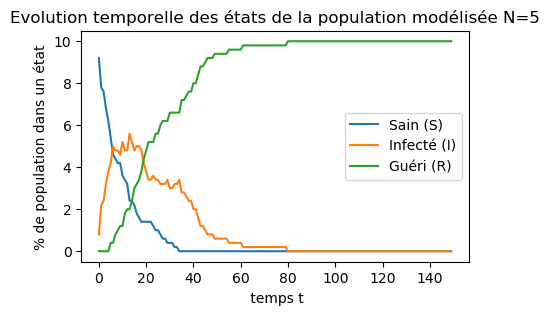

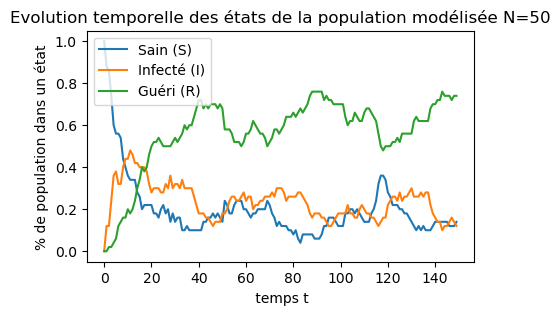

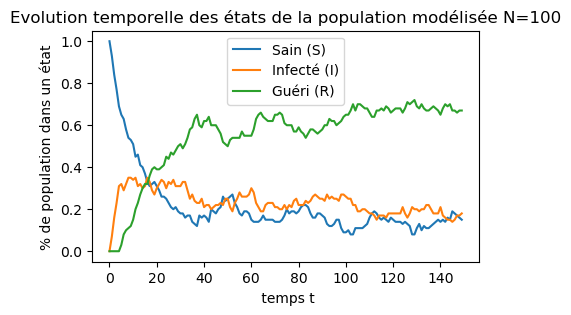

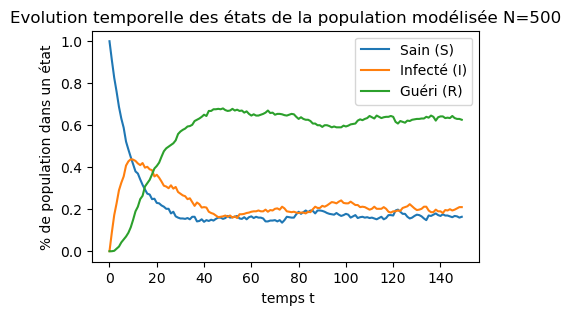

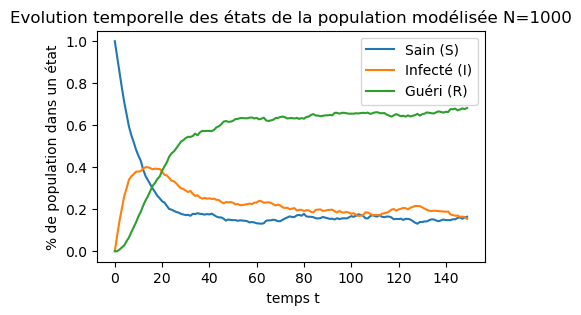

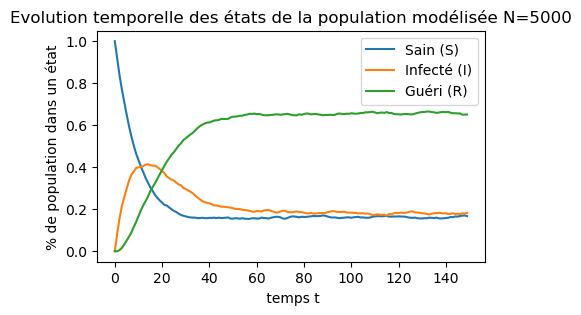

In [113]:
T = np.arange(150)

seq5 = gen_sequences_population(A,pi0,5,150)
prop5 = compteur(seq50,150,5)

seq50 = gen_sequences_population(A,pi0,50,150)
prop50 = compteur(seq50,150,50)

seq100 = gen_sequences_population(A,pi0,100,150)
prop100 = compteur(seq100,150,100)

seq500 = gen_sequences_population(A,pi0,500,150)
prop500 = compteur(seq500,150,500)

seq1000 = gen_sequences_population(A,pi0,1000,150)
prop1000 = compteur(seq1000,150,1000)

seq5000 = gen_sequences_population(A,pi0,5000,150)
prop5000 = compteur(seq5000,150,5000)


graph(T, prop5,"Evolution temporelle des états de la population modélisée N=5"," temps t","% de population dans un état")
graph(T, prop50,"Evolution temporelle des états de la population modélisée N=50"," temps t","% de population dans un état")
graph(T, prop100,"Evolution temporelle des états de la population modélisée N=100" ," temps t","% de population dans un état")
graph(T, prop500,"Evolution temporelle des états de la population modélisée N=500" ," temps t","% de population dans un état")
graph(T, prop1000,"Evolution temporelle des états de la population modélisée N=1000" ," temps t","% de population dans un état")
graph(T, prop5000,"Evolution temporelle des états de la population modélisée N=5000" ," temps t","% de population dans un état")

De même que pour l'experience avec la matrice précédente on remarque que les courbes sont assez similaires, plus la population est grande plus on va se rapprocher du graphique théorique.


Changeons maintenant la distibution de la population au temps t = 0, prenons $ \pi = [0.1,0.9,0]$

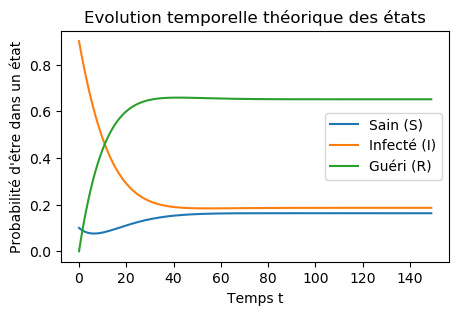

In [114]:
pi0 = np.array([.1,.9,0])

T = np.arange(150)
pi_t = np.zeros((150, 3))
for i in range(0, 150):
    pi_t[i] = distribution(pi0,A,i)
graph(T, pi_t,"Evolution temporelle théorique des états", "Temps t","Probabilité d'être dans un état")

En changeant la répartition des individus à l'état t = 0 la propotion d'individus sains et celle des individus infecté on été inversé étant donné la nouvelle distribution au temps t = 0 donné. De plus on observe que les courbes reviennent dans le meme état que précédement.

Essayons mainteneant avec plusieurs distribution initiale.

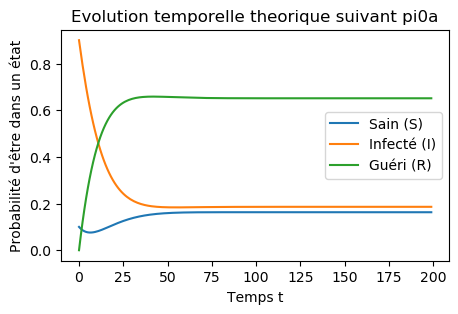

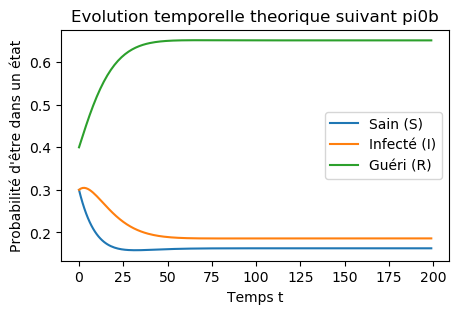

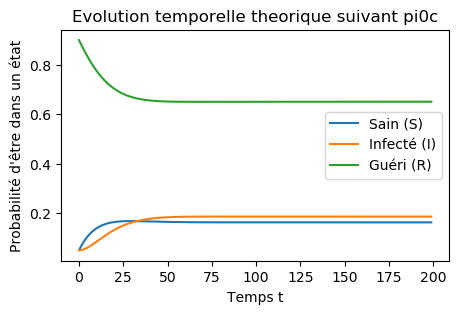

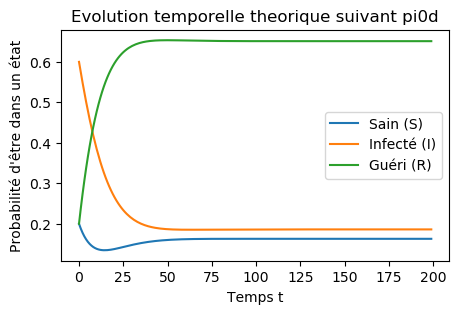

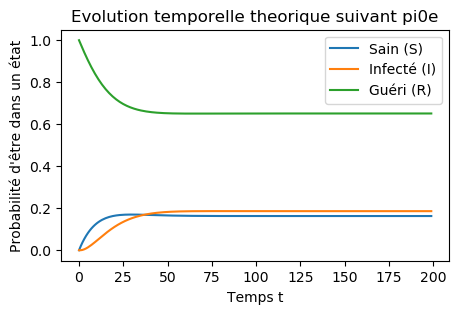

In [115]:
pi0a = np.array([0.1,0.9,0])
pi0b = np.array([0.3,0.3,0.4])
pi0c = np.array([0.05,0.05,0.9])
pi0d = np.array([0.20,0.60,0.20])
pi0e = np.array([0,0,1])

T = np.arange(200)

pi_ta = np.zeros((200, 3))
for i in range(0, 200):
    pi_ta[i] = distribution(pi0a,A,i)
graph(T, pi_ta,"Evolution temporelle theorique suivant pi0a", "Temps t","Probabilité d'être dans un état")

pi_tb = np.zeros((200, 3))
for i in range(0, 200):
    pi_tb[i] = distribution(pi0b,A,i)
graph(T, pi_tb,"Evolution temporelle theorique suivant pi0b", "Temps t","Probabilité d'être dans un état")

pi_tc = np.zeros((200, 3))
for i in range(0, 200):
    pi_tc[i] = distribution(pi0c,A,i)
graph(T, pi_tc,"Evolution temporelle theorique suivant pi0c", "Temps t","Probabilité d'être dans un état")
pi_td = np.zeros((200, 3))
for i in range(0, 200):
    pi_td[i] = distribution(pi0d,A,i)
graph(T, pi_td,"Evolution temporelle theorique suivant pi0d", "Temps t","Probabilité d'être dans un état")

pi_te = np.zeros((200, 3))
for i in range(0, 200):
    pi_te[i] = distribution(pi0e,A,i)
graph(T, pi_te,"Evolution temporelle theorique suivant pi0e", "Temps t","Probabilité d'être dans un état")

Suivant les differents pi0 on remarque des distributions assez similaires, en effet quand t est assez grand on peut remarquer que toutes les courbes stagnent mais pas au même niveau.


Pour retrouver la distribution de probabilité stationnaire on recherche un $\pi_t$ tel que $\pi_t = \pi_{-1}\times A$

In [116]:
An_1 = np.zeros_like(A)
An = A.copy()

def stationnaire(A, pi0):
    #Calcul de la distribution de probabilités stationnaire
    i=0
    An_1 = np.zeros_like(A)
    An = A.copy()
    while not np.all(An == An_1):
        An_1 = An.copy()
        An = np.matmul(pi0,np.linalg.matrix_power(A,i))
        i+=1
    return An

print("La distribution de probabilités stationnaire est", stationnaire(A,pi0))

La distribution de probabilités stationnaire est [0.1627907  0.18604651 0.65116279]


On remarque qu'avec t assez grand le taux d'individus guéris, sains et inféctés correspond à la distribution de probabilits stationnaire.

# Longueur d'immunité

On peut se demander combien de temps un individu qui a été malade, reste protégé contre la maladie.

Calculons alors la longueur d'une séquence de R sur une population de taille 5000. Nous pouvons donc procéder de la même manière que précédement seulement cette fois ci, il existe plusieurs sequence de R chez un individus. La moyenne se fait donc sur le total de nombre de sequence de R.


In [117]:
def nbR(p):
    # On compte la taille d'une seule sequence de R consécutive dans une population et on l'ajoute à une liste
    repR = 0
    nbR = []
    for j in p:
        for i in j:
            if i == 2:
                repR += 1
            if i != 2 and repR != 0:
                nbR.append( repR )
                repR = 0
    return nbR


#On somme toute la liste puis on divise par la taille de la liste pour afficher la moyenne
print("La moyenne d'une sequence de R sur une population de taille 5000 est de :",np.sum(nbR(seq5000))/len(nbR(seq5000)))

La moyenne d'une sequence de R sur une population de taille 5000 est de : 36.508473125641906


Calculons maintenant la longueur théorique d'une séquence de R. Procédons de la même façon que pour une séquence de I.

La probabilité que le temps de guérison soit égal à 1 est de $P(L == 1) = P(RS)$

La probabilité que le temps de guérison soit égal à 2 est de $P(L == 2) = P(RRS) = P(RR)\times P(RS)$

Notons alors $P(RS) = p$

Donc on a pour un temps t, le temps de guérison est égal à $P(L == t) = P(RR)^{t-1} \times p$

Cela correspond donc a une loi géometrique de probabilité p = 0.02


La longueur théorique d'une séquence de R pour t = 0 est donc de : 50.0


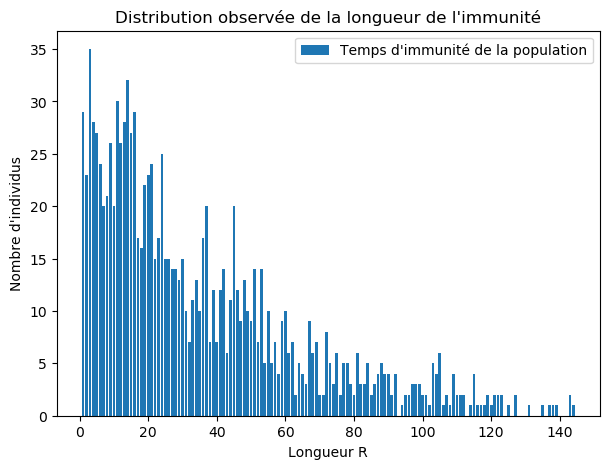

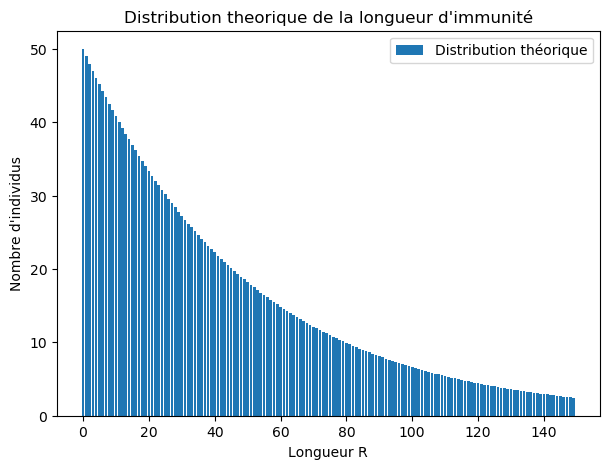

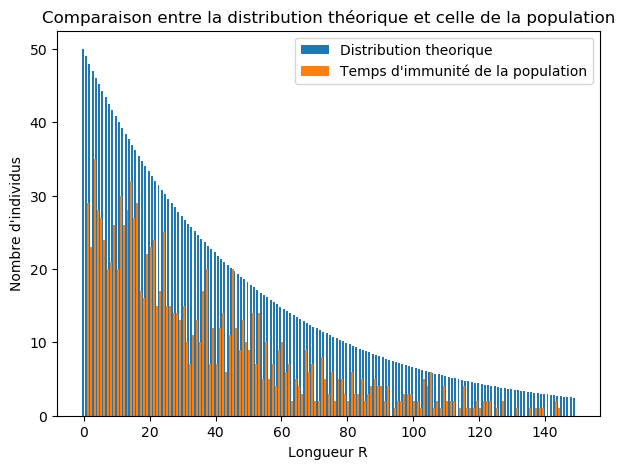

In [118]:
p = A[2][0]

print("La longueur théorique d'une séquence de R pour t = 0 est donc de :",1/p)

a = nbR(seq500)

val , indices = np.unique(a, return_counts=True)
histogramme(val, indices, "Distribution observée de la longueur de l'immunité", "Temps d'immunité de la population", "Longueur R", "Nombre d'individus")



longueur_i = np.zeros_like(a, dtype= float)
for i in range (0,len(a)):
    longueur_i[i] = (1-p)**i*(1/p)



L = np.arange(150)
histogramme(L, longueur_i[:150],"Distribution theorique de la longueur d'immunité","Distribution théorique","Longueur R", "Nombre d'individus")
histogramme2(L, longueur_i[:150],"Comparaison entre la distribution théorique et celle de la population","Distribution theorique",val,indices,"Temps d'immunité de la population","Longueur R", "Nombre d'individus")

On remarque que le temps d'immunité est beaucoup plus bas que celui théorique alors que le temps d'infection sur une population était à peu près équivalent à celui théorique.

### Modifier le modèle

En modifiant la probabilité pour un individu sain de devenir infecté :

[[0.08 0.92 0.  ]
 [0.   0.93 0.07]
 [0.02 0.   0.98]]
La distribution de probabilités stationnaire est [0.01662708 0.21852732 0.76484561]


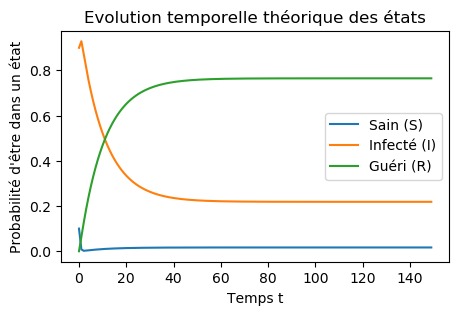

In [119]:
A = np.array([[.08, .92, .0], [.0, .93, .07], [.02, .0, .98]])
print(A)

print("La distribution de probabilités stationnaire est", stationnaire(A,pi0))

T = np.arange(150)
pi_t = np.zeros((150, 3))
for i in range(0, 150):
    pi_t[i] = distribution(pi0,A,i)
graph(T, pi_t,"Evolution temporelle théorique des états", "Temps t","Probabilité d'être dans un état")



On remarque que la distribution de probabilités stationnaire est à peu près équivalente, la probabilité d'être à l'état sain a beaucoup diminué, pour augmenter la probabilité d'être à l'état guéri. 


Changeons maintenant la probabilité pour un individu guéri de devenir sain

[[0.92 0.08 0.  ]
 [0.   0.93 0.07]
 [0.98 0.   0.02]]
La distribution de probabilités stationnaire est [0.44954128 0.51376147 0.03669725]


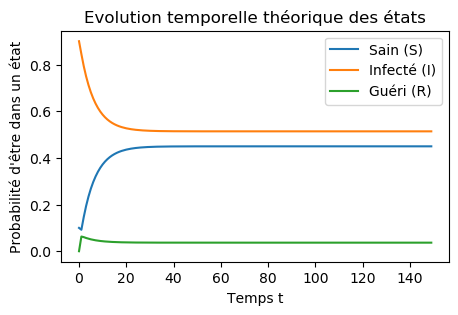

In [120]:
A = np.array([[.92, .08, .0], [.0, .93, .07], [.98, .0, .02]])
print(A)

print("La distribution de probabilités stationnaire est", stationnaire(A,pi0))

T = np.arange(150)
pi_t = np.zeros((150, 3))
for i in range(0, 150):
    pi_t[i] = distribution(pi0,A,i)
graph(T, pi_t,"Evolution temporelle théorique des états", "Temps t","Probabilité d'être dans un état")


Cette fois ci on remarque que la distribution de probabilité stationnaire a beaucoup changé, il y a beaucoup plus de chance d'être a l'état infecté ou guéri et beaucoup moins à l'état guéri.


## Partie 4 : Confinement


Nous allons maintenant imaginer que des mesures de distanciation sociale sont mises en place, c'est à dire que la probabilité de devenir infecté devient nulle.

Nous allons donc utiliser les deux matrices suivantes :

|  |S | I | R |
| :--|:--:| :--:|--:|
|S   | 0.92 | 0.08 |0|
|I   | 0 | 0.93 |0.07|
|R   |  0.02 |  0  |0.98|

Qui représente le cas où il n'y a pas de distanciation.


|  |S | I | R |
| :--|:--:| :--:|--:|
|S   | 1 | 0 |0|
|I   | 0 | 0.93 |0.07|
|R   |  0.02 |  0  |0.98|

Qui représente le cas où il y a distanciation.


On ne procède pas comme précédement. Pour **generation_sequence** et **generation_sequence_population** on genere une sequence individus par individus alors que pour **distsociale** il faut à chaque temps t, récupérer la distribution dans chaque état.

Nombre de confinement observé : 4
Nombre de déconfinement observé : 4


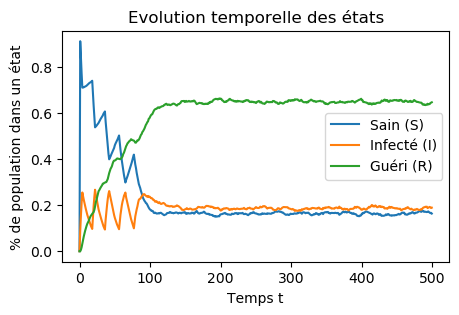

In [121]:
Confinement = np.array([[1, .0, .0], [.0, .93, .07], [.02, .0, .98]])
Deconfinement = np.array([[0.92, .08, .0], [.0, .93, .07], [.02, .0, 0.98]])

def distsociale(matconf,matdeconf,pi,t,n):
    #Simule un cas ou il y a un confinement et un deconfinement
    
    #On débute avec un deconfinement
    mat = matdeconf.copy()
    
    #Initialisation des variables
    res = np.zeros((t,3))
    seq = np.zeros((n,t))
    
    #Compteur pour le nombre de confinement et de deconfinement
    nbconf = 0
    nbdeconf = 0
    
    for i in range(1,t):
        for j in range(n):
            #Tout les individus sont à sain au départ
            if i == 1:
                seq[j][0] = 0
                
            #On choisit l'état suivant en fonction de l'état précédent
            seq[j][i] = np.random.choice([0.,1.,2.],1, p=mat[int(seq[j][i-1])])
            
            #On compte le nombre de sain, infecté et rétabli
            if seq[j][i] == 0:
                res[i][0]+=1
            if seq[j][i] == 1:
                res[i][1]+=1
            if seq[j][i] == 2:
                res[i][2]+=1
                
        #On divise afin d'obtenir un pourcentage
        res[i]/=n
        
        #Si on est en confinement et que la proportion d'infecté est inférieur à 10% alors il y a déconfinement
        if np.array_equal(mat, matconf):
            if res[i][1] <= 0.1:
                # print("deconfinement")
                nbdeconf+=1
                mat = matdeconf.copy()
        #Sinon si on est en deconfinement et si la proportion d'infecté est supérieur à 25% alors il y a confinement
        else:
            if res[i][1] >=0.25:
                nbconf+=1
                # print("confinement")
                mat = matconf.copy()

            
            
        
    print("Nombre de confinement observé :", nbconf)
    print("Nombre de déconfinement observé :", nbdeconf)
    
    return res

T = np.arange(500)
graph(T, distsociale(Confinement,Deconfinement,pi0,500,5000),"Evolution temporelle des états", "Temps t","% de population dans un état")


Sur plusieurs tests on remarque qu'il faut environ 4 à 5 confinements afin d'avoir des courbes d'états d'individu sain, infecté et guéri stable.